In [1]:
import os
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import geopandas as gpd
import rasterio as rio
from rasterio.plot import plotting_extent
import folium
import earthpy as et
import earthpy.plot as ep
import earthpy.spatial as es
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from datetime import date
from shapely.geometry import box

sns.set(font_scale=1.5, style="whitegrid")

In [2]:
os.chdir(os.path.join('P:\\Personal Files\\Education\\FRCC\\NSF_Internship\\NSF_Project_Files\\Data'))
#Variables
final_layers = os.path.join("Final_Results","Output_Layers")
results_flder = os.path.join("Final_Results","Input_Layers")
soil_layer = os.path.join(results_flder,"Soil_Hydro_Group_dummy.shp")
landuse_layer = os.path.join(results_flder,"Landuse_CN_Groups_dummy.shp")
slope_layer = os.path.join(results_flder,"Slope_Risk_dummy.shp")
CN_SoilLand_Risk = os.path.join(final_layers,"CN_Risk")
CN_RainSoilLand_Risk = os.path.join(final_layers,"CN_Rain_Risk")
Total_Risk = os.path.join(final_layers,"Total_Risk")
Flood_Risk = os.path.join(final_layers,"Flood_Risk")
dem_mosaic_outpath = os.path.join("Slope_Results","dem_mosaic_crop.tif")
#res boundary
res_path = os.path.join("Reservation_Boundary_Layer","BIA_National_LAR.shp")
res_boundary = gpd.read_file(res_path)
res_map_name = "Standing Rock" #name of reservation for the map display
res_aoi = res_boundary[res_boundary["LARName"] == "Standing Rock LAR"]
#Plotting Layers
projection = "epsg:26914"
pop_places = os.path.join("Map_Layers","gnispop_p_extract.shp")
roads = os.path.join("Map_Layers","road100k_l_extract.shp")
rivers = os.path.join("Map_Layers","nhd24kst_l_extract.shp")
rivers_a = os.path.join("Map_Layers","nhd24kar_a_extract.shp")
road_field = "RTTYP" #field of road type
road_vairable = ["C","M","S","U"] #road type primary road code, place in brackets for a list
river_field = "FCODE" #field name of stream type
river_vairable = [46000,46006] #stream code, place in brackets for a list
Arc_Results = os.path.join("ArcGIS","total_risk_diss.shp")

In [ ]:
#Files for Plotting

In [ ]:
soil_layer_r = gpd.read_file(soil_layer)
landuse_layer_r = gpd.read_file(landuse_layer)

In [ ]:
#join
CN_Risk_Join = gpd.overlay(soil_layer_r, landuse_layer_r, how='intersection')
CN_Risk_Join.head()

In [ ]:
print(len(landuse_layer_r))
print(len(soil_layer_r))
print(len(CN_Risk_Join))

In [ ]:
#add column
CN_Risk = CN_Risk_Join.assign(CN=0,CN_Risk=0)
print(CN_Risk.dtypes)
CN_Risk = CN_Risk.fillna(-9999)
CN_Risk.rename(columns={'CN-A':'CN_A'},inplace=True)
CN_Risk.rename(columns={'CN-B':'CN_B'},inplace=True)
CN_Risk.rename(columns={'CN-C':'CN_C'},inplace=True)
CN_Risk.rename(columns={'CN-D':'CN_D'},inplace=True)
CN_Risk['CN_A']=CN_Risk.CN_A.astype(int)
CN_Risk['CN_B']=CN_Risk.CN_B.astype(int)
CN_Risk['CN_C']=CN_Risk.CN_C.astype(int)
CN_Risk['CN_D']=CN_Risk.CN_D.astype(int)
print(CN_Risk.dtypes)
CN_Risk.head()

In [ ]:
CN_Risk['CN'] = np.where((CN_Risk['Hydrologic'] == 'A'),
                           CN_Risk['CN_A'],      
                           CN_Risk['CN'])
CN_Risk['CN'] = np.where((CN_Risk['Hydrologic'] == 'A/B'),
                         ((CN_Risk['CN_A']+CN_Risk['CN_B'])/2),
                         CN_Risk['CN'])
CN_Risk['CN'] = np.where((CN_Risk['Hydrologic'] == 'B'),
                           CN_Risk['CN_B'],      
                           CN_Risk['CN'])
CN_Risk['CN'] = np.where((CN_Risk['Hydrologic'] == 'B/C'),
                         ((CN_Risk['CN_B']+CN_Risk['CN_C'])/2),      
                         CN_Risk['CN'])
CN_Risk['CN'] = np.where((CN_Risk['Hydrologic'] == 'C'),
                           CN_Risk['CN_C'],      
                           CN_Risk['CN'])
CN_Risk['CN'] = np.where((CN_Risk['Hydrologic'] == 'C/D'),
                         ((CN_Risk['CN_C']+CN_Risk['CN_D'])/2),      
                         CN_Risk['CN'])
CN_Risk['CN'] = np.where((CN_Risk['Hydrologic'] == 'D'),
                           CN_Risk['CN_D'],      
                           CN_Risk['CN'])
CN_Risk

In [ ]:
CN_Risk["CN_Risk"] = 2
CN_Risk.loc[CN_Risk.CN > 70, 'CN_Risk'] = 3
CN_Risk.loc[CN_Risk.CN < 40, 'CN_Risk'] = 1
CN_Risk.loc[CN_Risk.CN == -9999, 'CN_Risk'] = -9999
CN_Risk

In [ ]:
#dissolve
CN_dis_prep = CN_Risk[['CN_Risk','geometry']]
CN_dis = CN_dis_prep.dissolve(by='CN_Risk')
CN_dis

In [ ]:
#Save File
CN_dis.to_file(CN_SoilLand_Risk)

In [ ]:
#join
slope_layer_r = gpd.read_file(slope_layer)
slope_layer_r.rename(columns={'raster_val':'Slope_risk'},inplace=True)
CN_SoilLand_Risk_r = gpd.read_file(CN_SoilLand_Risk)
Total_Risk_Join = gpd.overlay(CN_SoilLand_Risk_r,slope_layer_r,
                            how="intersection")
Total_Risk_Join.head()

In [ ]:
#Save File
Total_Risk_Join.to_file(Total_Risk)

In [ ]:
#add column
Total_Risk_r = gpd.read_file(Total_Risk)
calc_risk = Total_Risk_r.assign(Total_risk=0)
calc_risk.head()

In [ ]:
#fill in column
calc_risk["Total_risk"] = calc_risk["CN_Risk"] + calc_risk["Slope_risk"]
calc_risk.loc[calc_risk.CN_Risk == -9999, 'Total_risk'] = -9999
calc_risk.head()

In [ ]:
#dissolve
calc_risk_dis_prep = calc_risk[['Total_risk','geometry']]
calc_risk_dis = calc_risk_dis_prep.dissolve(by='Total_risk')
calc_risk_dis = calc_risk_dis.reset_index(0)
calc_risk_dis

In [ ]:
#add column
final_risk = calc_risk_dis.assign(Risk_Level=0)
final_risk.head()

In [ ]:
final_risk["Risk_Level"] = 2
final_risk.loc[final_risk.Total_risk > 6, 'Risk_Level'] = 3
final_risk.loc[final_risk.Total_risk < 4, 'Risk_Level'] = 1
final_risk.loc[final_risk.Total_risk == -9999, 'Risk_Level'] = -9999
final_risk

In [ ]:
#dissolve
final_risk_prep = final_risk[['Risk_Level','geometry']]
final_risk_diss = final_risk_prep.dissolve(by='Risk_Level')
final_risk_diss = final_risk_diss.reset_index(0)
final_risk_diss

In [ ]:
final_risk_diss = final_risk_diss.assign(Flood_Risk="empty",Area=0,Acres=0)
final_risk_diss.loc[final_risk_diss.Risk_Level == 3, 'Flood_Risk'] = "High"
final_risk_diss.loc[final_risk_diss.Risk_Level == 2, 'Flood_Risk'] = "Medium"
final_risk_diss.loc[final_risk_diss.Risk_Level == 1, 'Flood_Risk'] = "Low"
final_risk_diss.loc[final_risk_diss.Risk_Level == -9999, 'Flood_Risk'] = "No Value"
final_risk_diss

In [ ]:
final_risk_diss["Area"] = final_risk_diss['geometry'].area
final_risk_diss["Acres"] = final_risk_diss['Area']/4046.85642
final_risk_diss

In [ ]:
#Save File
final_risk_diss.to_file(Flood_Risk)

In [ ]:
#Plot Data

In [3]:
#Vector Layers
#reservation
res_area = res_aoi.to_crs(projection)
#cities
cities = gpd.read_file(pop_places)
#cities_prj = cities.to_crs(projection)
bound_cities = gpd.clip(cities,res_area)
#roads
road_file = gpd.read_file(roads)
#road_primary = road_file[road_file[road_field] == road_vairable]
#road_prj = road_primary.to_crs(projection)
bound_road = gpd.clip(road_file,res_area)
#rivers
river_file = gpd.read_file(rivers_a)
bound_rivers = gpd.clip(river_file,res_area)
stream_file = gpd.read_file(rivers)
streams = stream_file[stream_file[river_field].isin(river_vairable)]
#streams_prj = streams.to_crs(projection)
bound_streams = gpd.clip(streams,res_area)

In [5]:
#results
#Arc_Results
flod_h = ['High']
flod_m = ['Medium']
flod_l = ['Low']
Flood_Results = gpd.read_file(Arc_Results)
Flood_Results_H = Flood_Results[Flood_Results['Flood_Risk'].isin(flod_h)]
Flood_Results_M = Flood_Results[Flood_Results['Flood_Risk'].isin(flod_m)]
Flood_Results_L = Flood_Results[Flood_Results['Flood_Risk'].isin(flod_l)]

In [ ]:
Flood_Risk_fig = os.path.join("Figures","Flood_Risk.png")
mapping_risk = gpd.read_file(Flood_Risk)
f, ax1 = plt.subplots(figsize=(20,20))
Flood_Results.plot(column='Flood_Risk', 
                categorical=False, 
                legend=True, 
                cmap="tab10", ax=ax1)
res_area.plot(color='None',
            Edgecolor='black',ax=ax1)
ax1.set(title="Soil by Hydrologic Group")
plt.show()
#plt.draw()
#f.savefig(Flood_Risk_fig, dpi=600)

In [6]:
#Raster Layers
with rio.open(dem_mosaic_outpath) as dem_src:

    # Project boundary to match raster data
    res_projected = res_aoi.to_crs(dem_src.crs)

    # Crop raster data to boundary
    dem_data_crop, dem_meta_crop = es.crop_image(
        dem_src, res_projected)

# Define plotting extent using cropped array and transform from metadata
dem_crop_plot_extent = plotting_extent(
    dem_data_crop[0], dem_meta_crop["transform"])
    

squeezed_dem = dem_data_crop.squeeze()

dem_hillshade = es.hillshade(squeezed_dem)

#with rio.open(Flood_Risk) as src:
#    flood_results = src.read(1)
#    flood_extent = plotting_extent(flood_results[0], flood_results.meta["transform"])

In [ ]:
print(Flood_Results['Flood_Risk'].unique())

In [ ]:
floodPalette = {'Low': 'yellow',
               'Medium': 'orange',
               'High': 'red',
               'No Value': 'lightgrey'}

P:\My_Programs\miniconda\envs\earth-analytics-python\lib\site-packages\geopandas\plotting.py:573: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "Only specify one of 'column' or 'color'. Using 'color'.", UserWarning
P:\My_Programs\miniconda\envs\earth-analytics-python\lib\site-packages\geopandas\plotting.py:573: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "Only specify one of 'column' or 'color'. Using 'color'.", UserWarning
P:\My_Programs\miniconda\envs\earth-analytics-python\lib\site-packages\geopandas\plotting.py:573: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "Only specify one of 'column' or 'color'. Using 'color'.", UserWarning


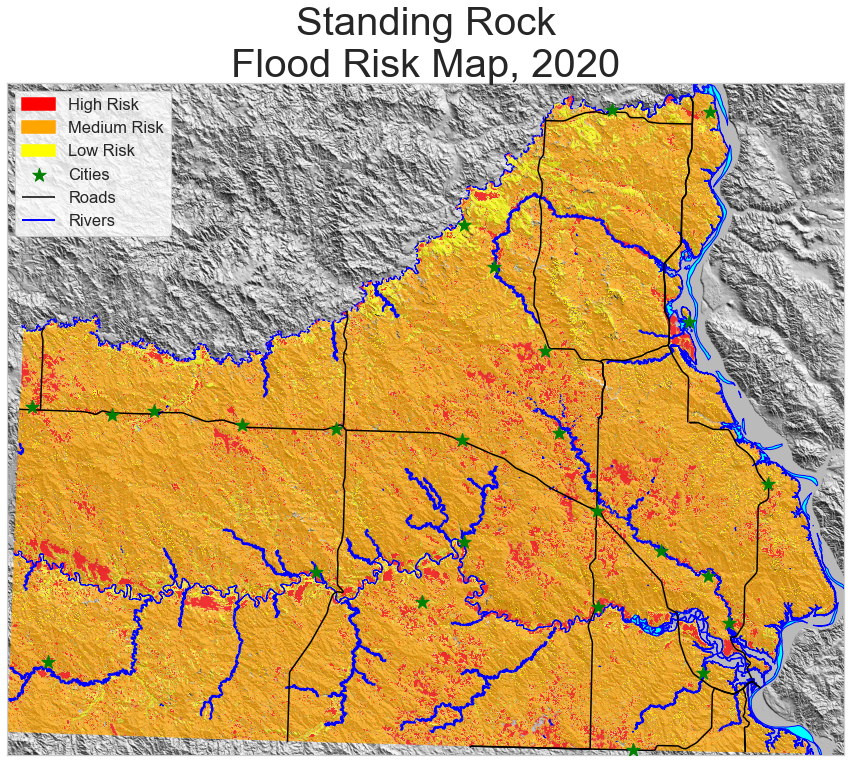

<Figure size 432x288 with 0 Axes>

In [12]:
final_fig = os.path.join("Figures","Final_Map.png")
# Plot the data
fig, ax = plt.subplots(figsize=(15, 15))

#Hillshade
ep.plot_bands(dem_hillshade,
              cmap='gray',
              extent=dem_crop_plot_extent,
              ax=ax,
              cbar=False)

#Flood Risk
Flood_Results_H.plot(color='red',
                     column='Flood_Risk',
                     edgecolor='None',
                     label='High Risk',
                     alpha=0.75,
                     legend=True,
                     ax=ax)

Flood_Results_M.plot(color='orange',
                     column='Flood_Risk',
                     edgecolor='None',
                     label='Medium Risk',
                     alpha=0.75,
                     legend=True,
                     ax=ax)

Flood_Results_L.plot(color='yellow',
                     column='Flood_Risk',
                     edgecolor='None',
                     label='Low Risk',
                     alpha=0.75,
                     legend=True,
                     ax=ax)

#Refuge Boundary
#res_area.plot(color='None',
#              edgecolor='indigo',
#              ax=ax,
#              linewidth=4)

#Cities
bound_cities.plot(color='green',
                  marker='*',
                  markersize=200,
                  label='Cities',
                  legend=True,
                  ax=ax,
                  zorder=3)

#Roads
bound_road.plot(color='black',
                label='Roads',
                ax=ax,
                legend=True,
                zorder=2)

#Rivers
bound_streams.plot(color='blue',
                   linewidth=2,
                   label='Rivers',
                   ax=ax,
                   legend=True,
                   zorder=1)

bound_rivers.plot(color='cyan',
                  edgecolor='blue',
                  ax=ax,
                  zorder=1)

import matplotlib.patches as patches
rect1 = patches.Rectangle((0,0),1,1,linewidth=1.5,label="High Risk", color="red")
rect2 = patches.Rectangle((0,0),1,1,linewidth=1.5,label="Medium Risk", color="orange")
rect3 = patches.Rectangle((0,0),1,1,linewidth=1.5,label="Low Risk", color="yellow")
plt.gca().add_patch(rect1)
plt.gca().add_patch(rect2)
plt.gca().add_patch(rect3)

#Legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
#plt.legend('fontsize'=40)
#Title
tyear = str(date.today().year)
ax.set_title(res_map_name+"\nFlood Risk Map, "+tyear,fontsize=40)

plt.show()
plt.draw()
fig.savefig(final_fig, dpi=400)